In [4]:
#Librerie utili
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from scipy import stats 
import scipy.stats as st

In [5]:
con = sqlite3.connect("../code/omnet/simulations/results/simulate.sca")

In [6]:
dfThroughput=pd.read_sql_query("""
select scenario, config, clients, CAST(attrValue as INT), statCount / 3600.0 as throughput
from runConfig rc inner join statistic s on rc.runId = s.runId
        inner join runAttr ra on s.runId = ra.runId
where statName = "completedTransactions:stats"
 AND attrName = "repetition"
order by scenario, config, clients,  CAST(attrValue as INT)
""", con)

In [7]:
dfResponseTime=pd.read_sql_query("""
SELECT clients, scenario, config,CAST(attrValue as INT),statMean as responseTime 
from runConfig rc inner join statistic s on rc.runId = s.runId
        inner join runAttr ra on s.runId = ra.runId
WHERE 
		statName = "responseTimeStat:stats" AND
		moduleName = "Network"
        AND attrName = "repetition"
ORDER BY scenario, config, clients, CAST(attrValue as INT)
""", con)

In [8]:
scenarios = ["s1","s2","s3","s4"]

In [9]:
dfThroughput['throughput_mean'] = dfThroughput.groupby(['scenario','config','clients'])['throughput'].transform('mean')
dfThroughput['throughput_residual'] = dfThroughput['throughput'] - dfThroughput['throughput_mean']
dfResponseTime['responseTime_mean'] = dfResponseTime.groupby(['scenario','config','clients'])['responseTime'].transform('mean')
dfResponseTime['responseTime_residual'] = dfResponseTime['responseTime'] - dfResponseTime['responseTime_mean']


## Throughput

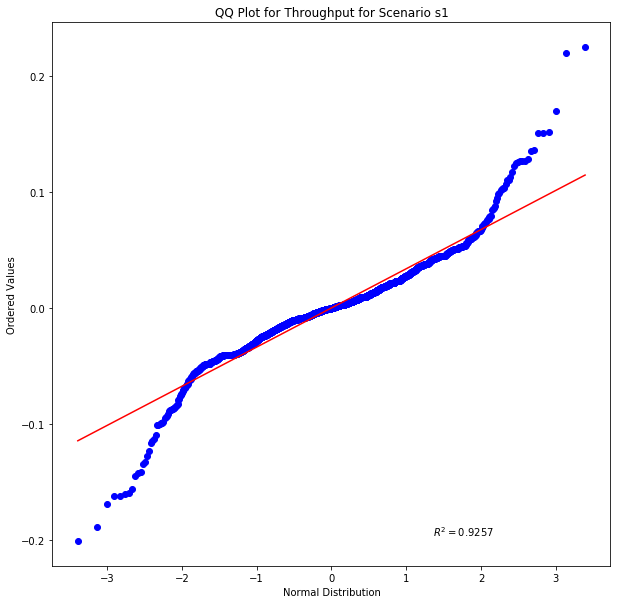

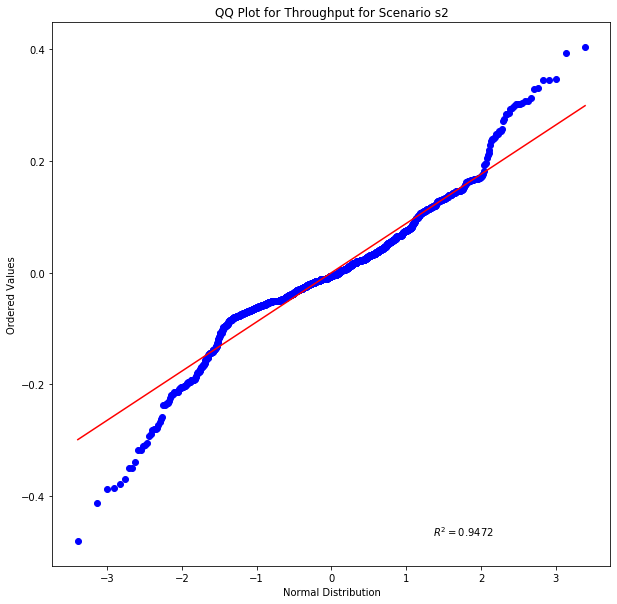

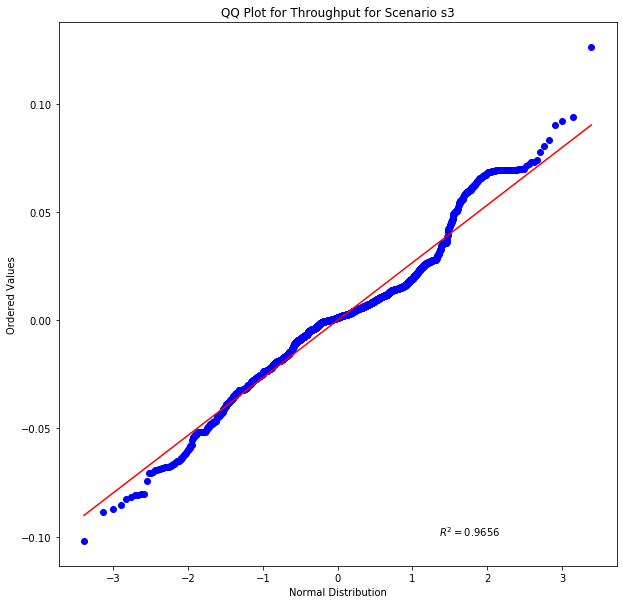

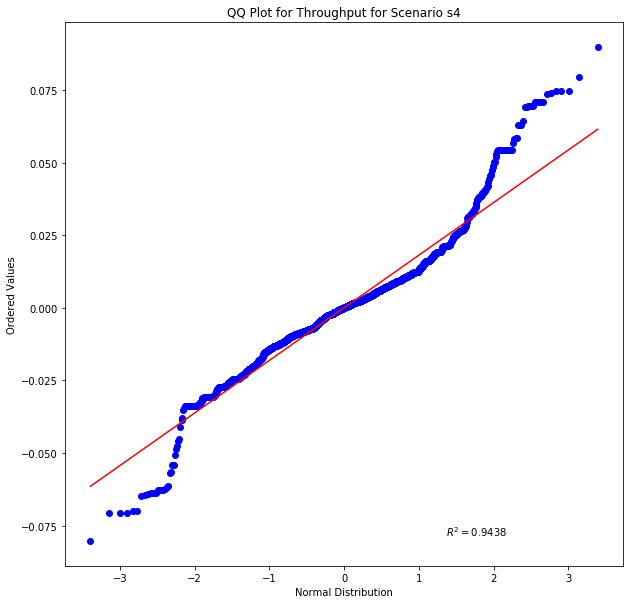

In [10]:
#Normality Test

for scenario in scenarios:
    #Set the dimensions of the plot
    plt.figure(figsize=(10,10))

    repThroughput=dfThroughput.loc[(dfThroughput['scenario']==scenario)]['throughput_residual']
    qqPlot = stats.probplot(list(repThroughput), dist='norm',plot=plt,rvalue=True)
    plt.title("QQ Plot for Throughput for Scenario "+scenario)
    plt.xlabel("Normal Distribution")


Normality assumption hold

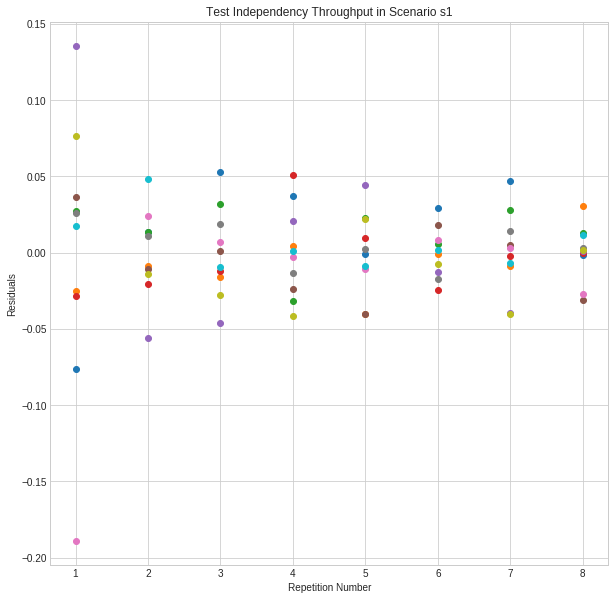

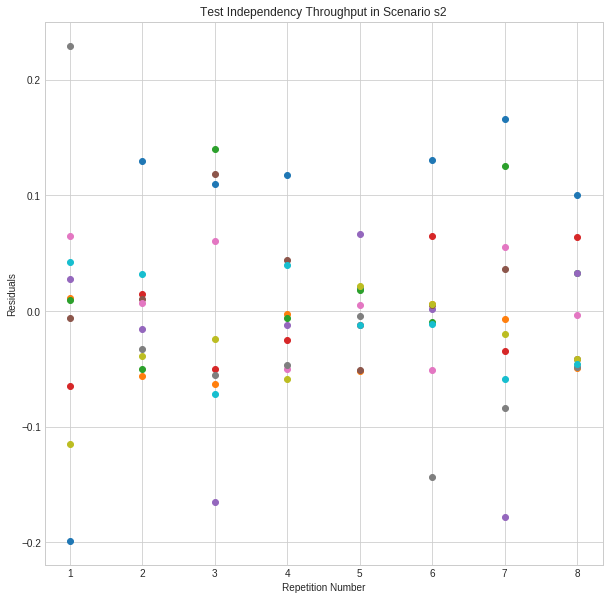

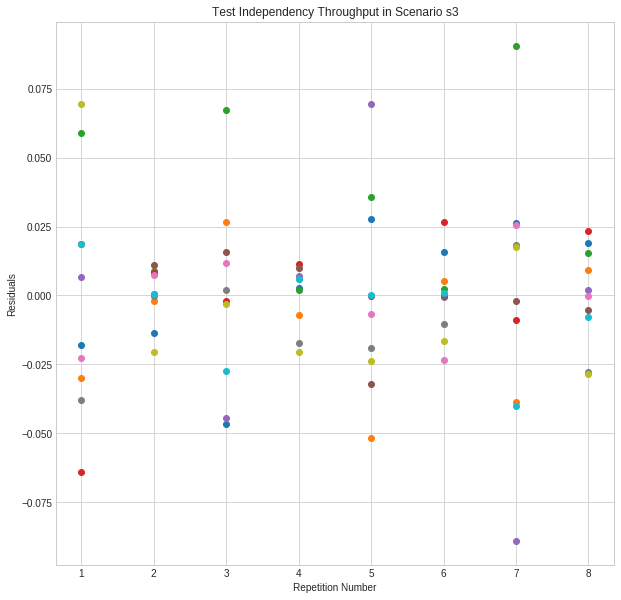

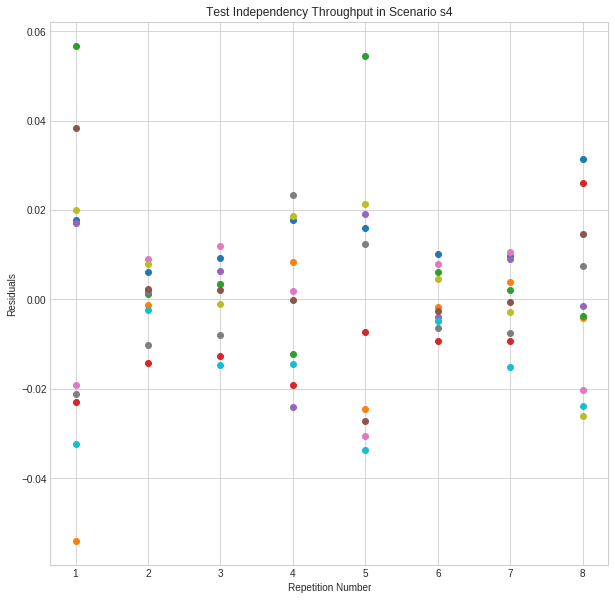

In [11]:
#Independency


for scenario in scenarios:
    y = []
    for repetition in range(0,10) :
        #print(dfThroughput.loc[(dfThroughput["clients"] == 49) & (scenario == dfThroughput["scenario"]) & (repetition == dfThroughput["CAST(attrValue as INT)"])]["throughput_residual"].values.tolist())
        sublist = dfThroughput.loc[(dfThroughput["clients"] == 49) & (scenario == dfThroughput["scenario"]) & (repetition == dfThroughput["CAST(attrValue as INT)"])]["throughput_residual"].values.tolist()
        y.append(sublist)
    #Set the dimensions of the plot
    plt.figure(figsize=(10,10))
    plt.style.use('seaborn-whitegrid')
    y = list(map(list, zip(*y)))
    x=[*range(1,len(y)+1,1)]
    plt.plot(x, y, 'o')


    plt.title("Test Independency Throughput in "+"Scenario "+scenario)
    plt.xlabel("Repetition Number")
    plt.ylabel("Residuals")


Independency assumption hold, no visible trend

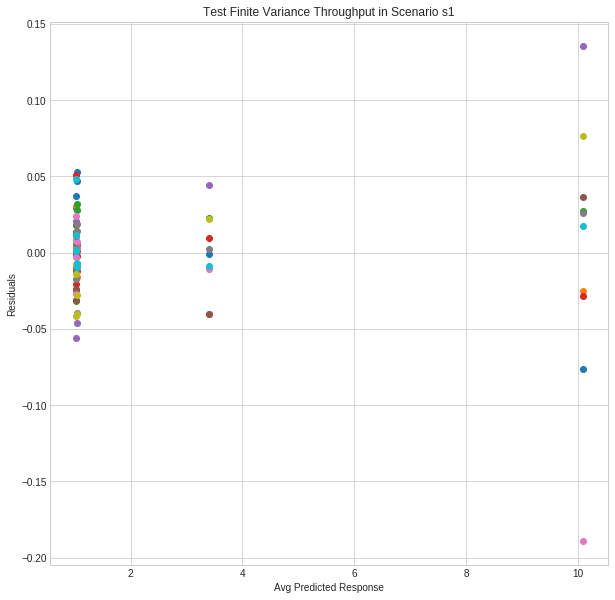

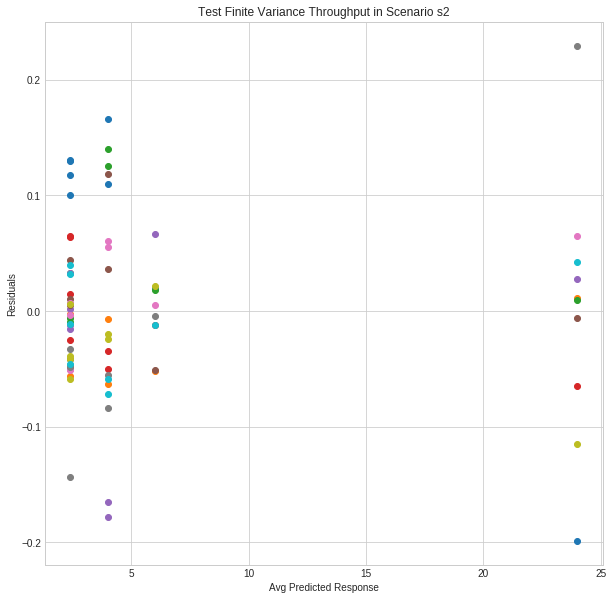

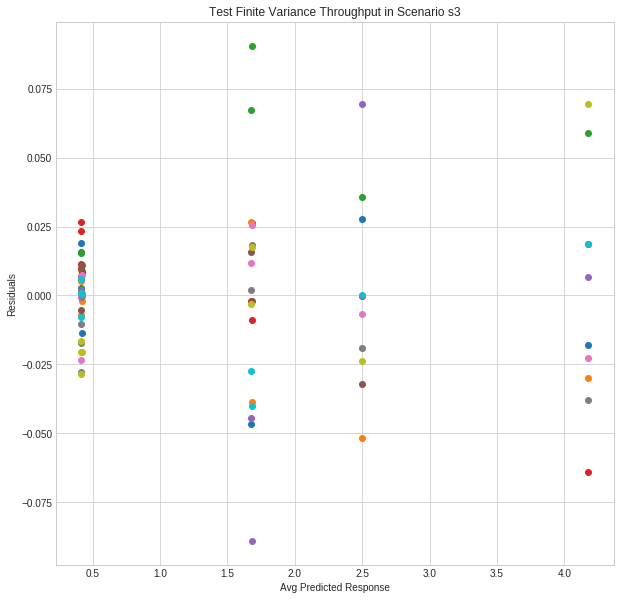

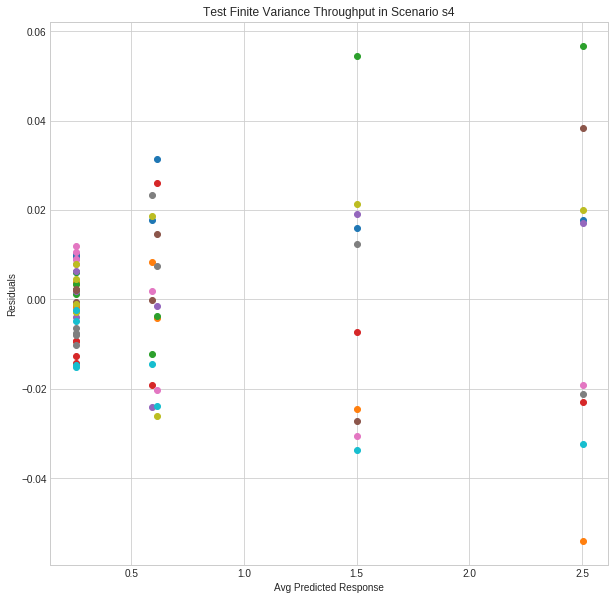

In [12]:
#Finite Variance
for scenario in scenarios:
    y = []
    for repetition in range(0,10) :
        #print(dfThroughput.loc[(dfThroughput["clients"] == 49) & (scenario == dfThroughput["scenario"]) & (repetition == dfThroughput["CAST(attrValue as INT)"])]["throughput_residual"].values.tolist())
        sublist = dfThroughput.loc[(dfThroughput["clients"] == 49) & (scenario == dfThroughput["scenario"]) & (repetition == dfThroughput["CAST(attrValue as INT)"])]["throughput_residual"].values.tolist()
        y.append(sublist)
    
    #Set the dimensions of the plot
    plt.figure(figsize=(10,10))
    plt.style.use('seaborn-whitegrid')
    y = list(map(list, zip(*y)))

    x=dfThroughput.loc[(dfThroughput["clients"] == 49) & (scenario == dfThroughput["scenario"]) & (repetition == dfThroughput["CAST(attrValue as INT)"])]["throughput_mean"].values.tolist()
    plt.plot(x, y, 'o')


    plt.title("Test Finite Variance Throughput in "+"Scenario "+scenario)
    plt.xlabel("Avg Predicted Response")
    plt.ylabel("Residuals")


Slightly increasing trend, but residuals are two order of magnitude smaller then avg predicted response, so the hypothesys holds

## Response Time

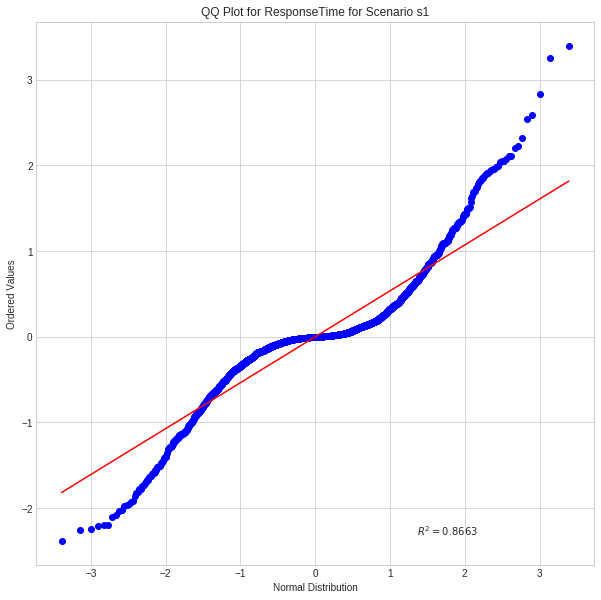

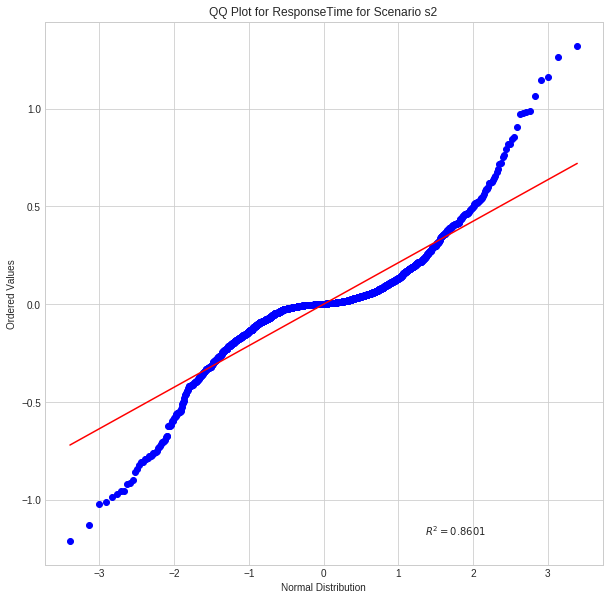

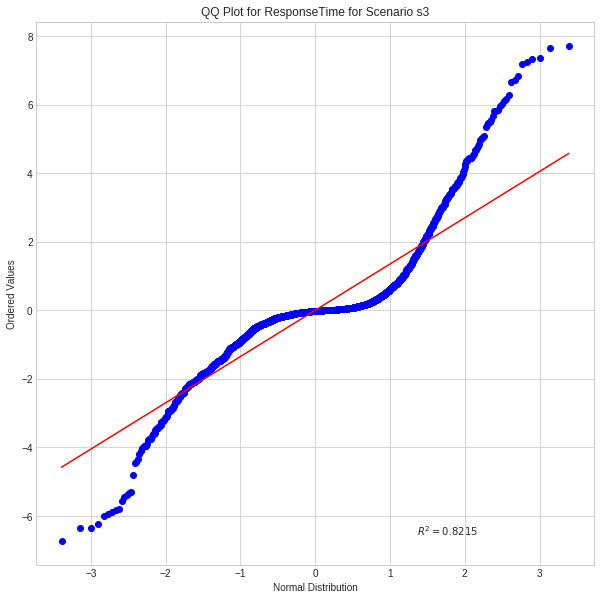

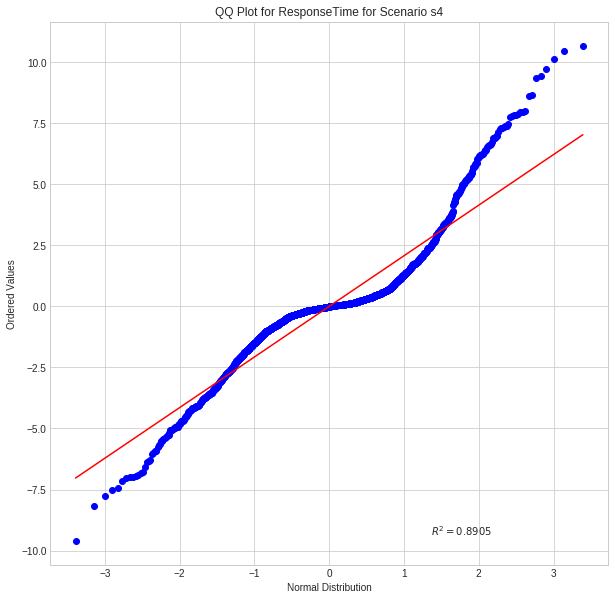

In [10]:
for scenario in scenarios:
    #Set the dimensions of the plot
    plt.figure(figsize=(10,10))


    repResponseTime=dfResponseTime.loc[(dfResponseTime['scenario']==scenario)]['responseTime_residual']
    qqPlot = stats.probplot(list(repResponseTime), dist=st.norm(0,1),plot=plt,rvalue=True)
    plt.title("QQ Plot for ResponseTime for Scenario "+scenario)
    plt.xlabel("Normal Distribution")

Not so satisfactory results, it's not a straight line. Seems that the distribution may have longer tails

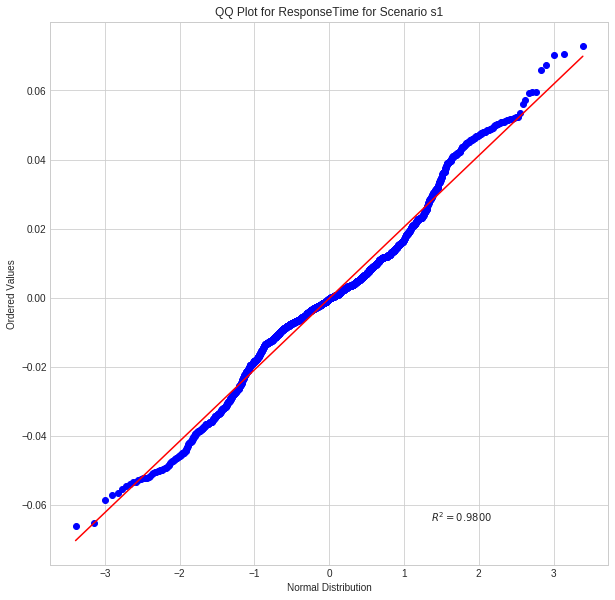

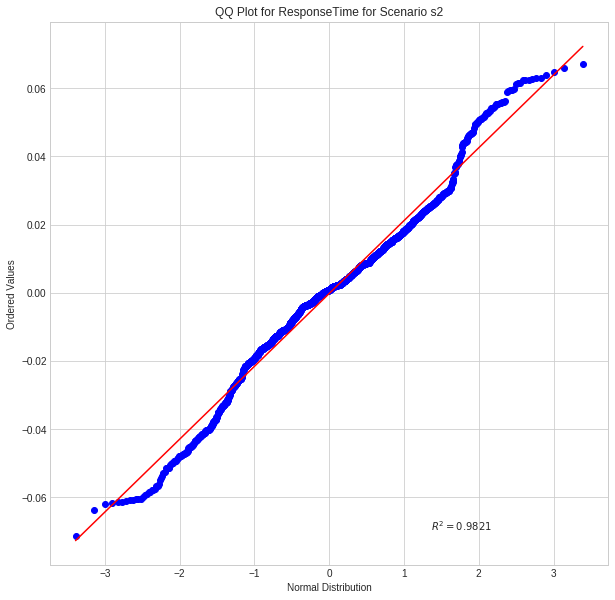

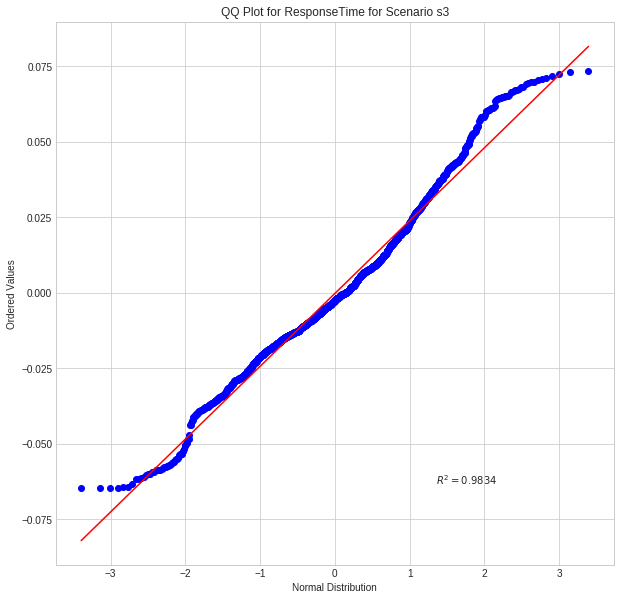

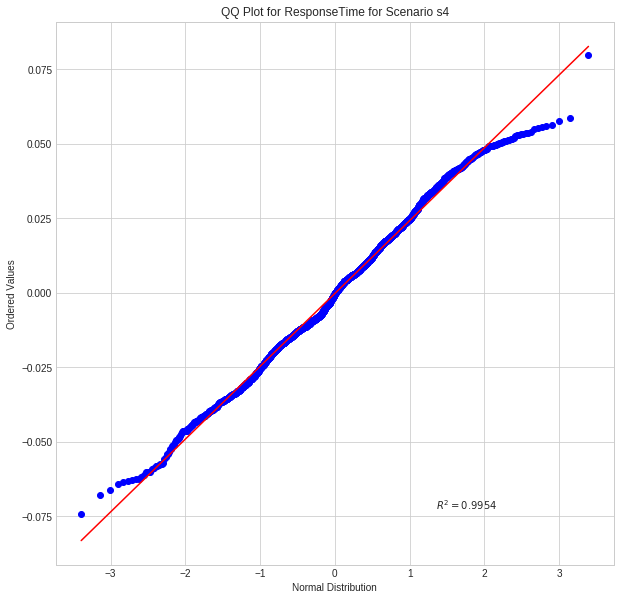

In [11]:
#Trying with log transform

dfResponseTime['responseTime_mean_log'] = np.log(dfResponseTime.groupby(['scenario','config','clients'])['responseTime'].transform('mean'))
dfResponseTime['responseTime_residual_log'] = np.log(dfResponseTime['responseTime']) - dfResponseTime['responseTime_mean_log']

for scenario in scenarios:
    #Set the dimensions of the plot
    plt.figure(figsize=(10,10))


    repResponseTime=dfResponseTime.loc[(dfResponseTime['scenario']==scenario)]['responseTime_residual_log']
    qqPlot = stats.probplot(list(repResponseTime), dist=st.norm(0,1),plot=plt,rvalue=True)
    plt.title("QQ Plot for ResponseTime for Scenario "+scenario)
    plt.xlabel("Normal Distribution")

With log transform we have a better result, the residual now seems to be normally distributed.

In [ ]:
#Independency


for scenario in scenarios:
    y = []
    for repetition in range(0,10) :
       
        sublist = dfResponseTime.loc[(dfResponseTime["clients"] == 49) & (scenario == dfResponseTime["scenario"]) & (repetition == dfResponseTime["CAST(attrValue as INT)"])]["responseTime_residual"].values.tolist()
        y.append(sublist)
    #Set the dimensions of the plot
    plt.figure(figsize=(10,10))
    plt.style.use('seaborn-whitegrid')
    y = list(map(list, zip(*y)))
    x=[*range(1,len(y)+1,1)]
    plt.plot(x, y, 'o')


    plt.title("Test Independency Response Time in "+"Scenario "+scenario)
    plt.xlabel("Repetition Number")
    plt.ylabel("Residuals")


Independency assumption holds, no visible trend

In [ ]:
#Finite Variance


for scenario in scenarios:
    y = []
    for repetition in range(0,10) :
       
        sublist = dfResponseTime.loc[(dfResponseTime["clients"] == 49) & (scenario == dfResponseTime["scenario"]) & (repetition == dfResponseTime["CAST(attrValue as INT)"])]["responseTime_residual"].values.tolist()
        y.append(sublist)
    #Set the dimensions of the plot
    plt.figure(figsize=(10,10))
    plt.style.use('seaborn-whitegrid')
    y = list(map(list, zip(*y)))
    x=dfResponseTime.loc[(dfResponseTime["clients"] == 49) & (scenario == dfResponseTime["scenario"]) & (repetition == dfResponseTime["CAST(attrValue as INT)"])]["responseTime_mean"].values.tolist()
        
    plt.plot(x, y, 'o')


    plt.title("Test Finite Variance Response Time in "+"Scenario "+scenario)
    plt.xlabel("Avg Predicted Response")
    plt.ylabel("Residuals")

In [ ]:
#Finite Variance


for scenario in scenarios:
    y = []
    for repetition in range(0,10) :
       
        sublist = dfResponseTime.loc[(dfResponseTime["clients"] == 49) & (scenario == dfResponseTime["scenario"]) & (repetition == dfResponseTime["CAST(attrValue as INT)"])]["responseTime_residual"].values.tolist()
        y.append(sublist)
    #Set the dimensions of the plot
    plt.figure(figsize=(10,10))
    plt.style.use('seaborn-whitegrid')
    y = list(map(list, zip(*y)))
    x=dfResponseTime.loc[(dfResponseTime["clients"] == 49) & (scenario == dfResponseTime["scenario"]) & (repetition == dfResponseTime["CAST(attrValue as INT)"])]["responseTime_mean"].values.tolist()
        
    plt.plot(x, y, 'o')


    plt.title("Test Finite Variance Response Time in "+"Scenario "+scenario)
    plt.xlabel("Avg Predicted Response")
    plt.ylabel("Residuals")

Finite variance test shows that variance has an increasing tendency, the residuals are one order of magnitude smaller than the average predicted response, so this hypothesis seems to be respected, we can try to see what happens using log transformation

In [ ]:
for scenario in scenarios:
    y = []
    for repetition in range(0,10) :
       
        sublist = dfResponseTime.loc[(dfResponseTime["clients"] == 49) & (scenario == dfResponseTime["scenario"]) & (repetition == dfResponseTime["CAST(attrValue as INT)"])]["responseTime_residual_log"].values.tolist()
        y.append(sublist)
    #Set the dimensions of the plot
    plt.figure(figsize=(10,10))
    plt.style.use('seaborn-whitegrid')
    y = list(map(list, zip(*y)))
    x=dfResponseTime.loc[(dfResponseTime["clients"] == 49) & (scenario == dfResponseTime["scenario"]) & (repetition == dfResponseTime["CAST(attrValue as INT)"])]["responseTime_mean_log"].values.tolist()
        
    plt.plot(x, y, 'o')


    plt.title("Test Finite Variance Response Time in "+"Scenario "+scenario)
    plt.xlabel("Avg Predicted Response")
    plt.ylabel("Residuals")

The increasing trend now as expected is mitigated from data transformation